<a href="https://colab.research.google.com/github/sfkunal/TwitterSentiment/blob/master/FinalTwitterSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#updated 9.22.20

#Kunal Srivastava, Ayaan Rahim, Ryan Tabrizi
#Anti-Hate Speech Filter for Twitter

#dataset description: about 1,600,000 tweets approximately evenly split 
#                     between positive and negative binary classifications

# GPU Setup

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Wed Sep 23 06:25:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports and Setup

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow Version 2.3.0


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/TwitterAlgorithm

Mounted at /content/gdrive
/content/gdrive/My Drive/TwitterAlgorithm


# Data Preprocessing

In [5]:
#Importing dataset
df = pd.read_csv('twitterdata.csv', encoding = 'latin',header=None)
#Naming columns and dropping unnecessary columns
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
#Renaming 0 and 4 sentiments to negative and positive
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))

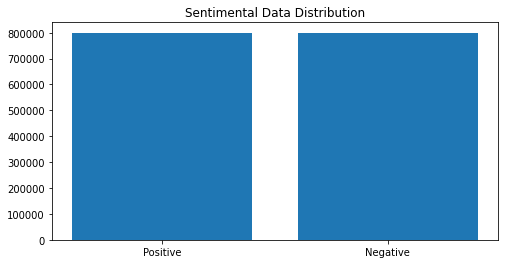

In [7]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentimental Data Distribution")
plt.savefig('data_distribution')

# Text Preprocessing

In [8]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)
  df.text = df.text.apply(lambda x: preprocess(x))

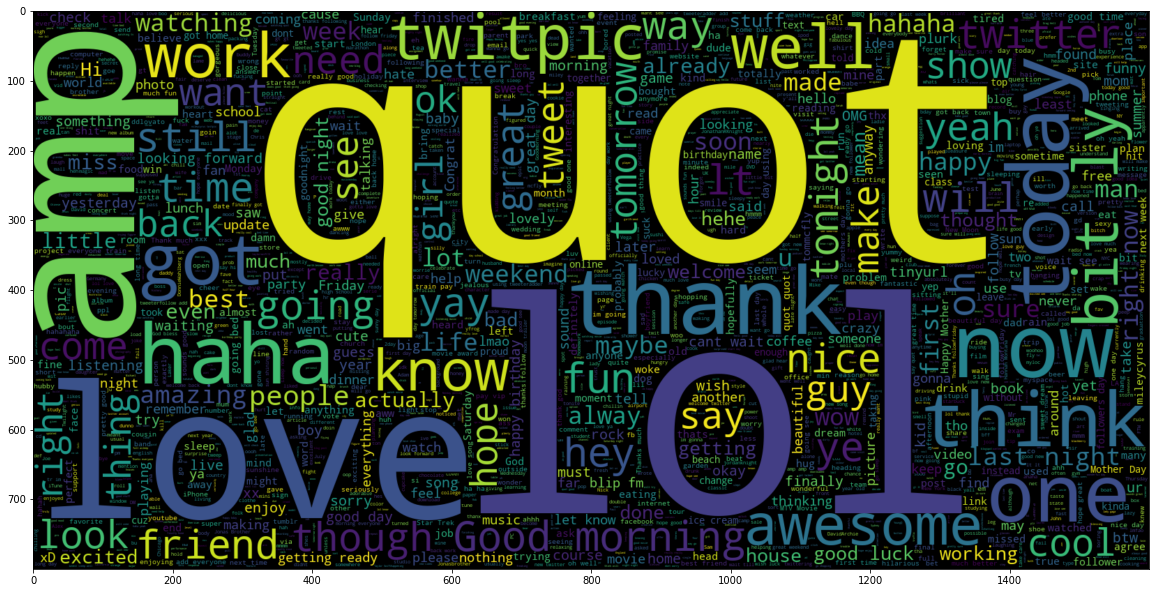

In [9]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('positive wordcloud')

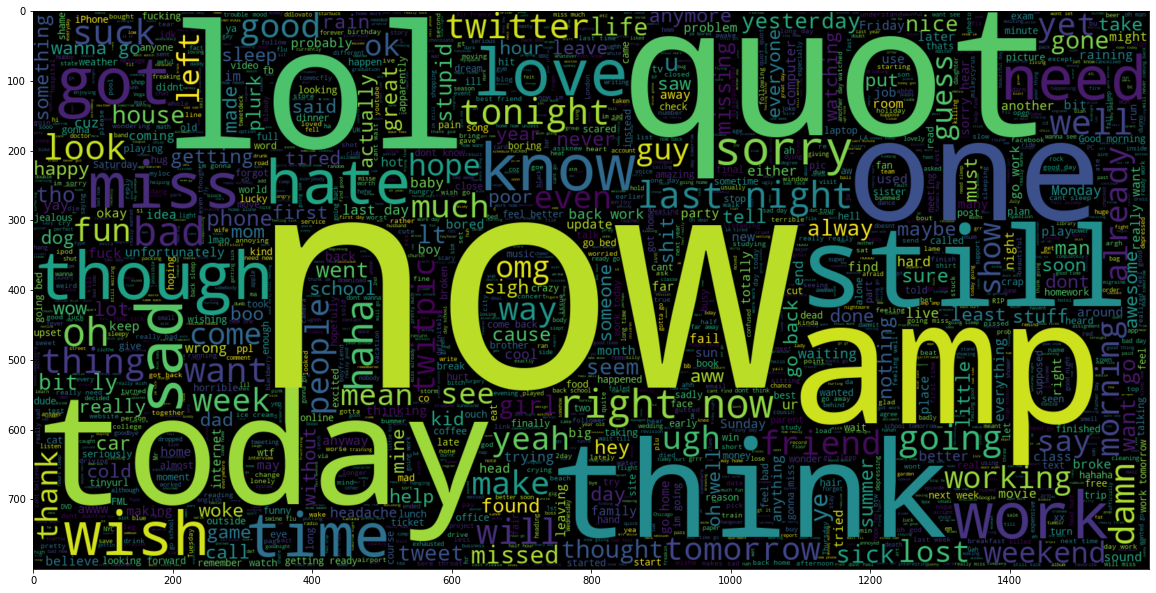

In [10]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('negative wordcloud')

In [11]:
TEST_SIZE = 0.2
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [12]:
train_data, test_data = train_test_split(df, test_size=TEST_SIZE, random_state=7)

print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [13]:
train_data.head(10)

,sentiment,text
23786,Negative,i need friends
182699,Negative,@IAMtheCOMMODORE im trying to call! but is im...
476661,Negative,@davemclellan Had a good pace going (3k after ...
1181490,Positive,@BHinesTheReal are u gonna be doing any shows ...
878773,Positive,@Buenobye Hell yea get em into tattoos so they...
130866,Negative,"Yeah, where? but I need 2 see if ur mom calls ..."
1235876,Positive,@AnnieMcBeth Sounds like my cup of tea. Where ...
717314,Negative,"i'm tired but i don't want to sleep, wtf"
969880,Positive,@lilyroseallen http://twitpic.com/5dflq - Amaz...
748698,Negative,Thank god WKRN ABC affiliate for Nashville is ...


# Tokenization

In [14]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1


In [15]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

In [16]:
labels = train_data.sentiment.unique().tolist()

In [17]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Word Embedding

In [18]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [19]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [20]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [21]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# Model Building

In [25]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [23]:
def create_model():
  sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedding_sequences = embedding_layer(sequence_input)
  x = SpatialDropout1D(0.2)(embedding_sequences)
  x = Conv1D(64, 5, activation='relu')(x)
  x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(512, activation='relu')(x)
  outputs = Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(sequence_input, outputs)

  return model

In [26]:
model = create_model()

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           178524900 
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 64)            96064     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

In [28]:
history = model.fit(x_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test), 
                    callbacks=[ReduceLROnPlateau])
model.save('model/twitter_sentiment_model') 

Epoch 1/10
1250/1250 [==============================] - 104s 83ms/step - loss: 0.4802 - accuracy: 0.7678 - val_loss: 0.4391 - val_accuracy: 0.7952
Epoch 2/10
1250/1250 [==============================] - 103s 83ms/step - loss: 0.4456 - accuracy: 0.7903 - val_loss: 0.4257 - val_accuracy: 0.8016
Epoch 3/10
1250/1250 [==============================] - 103s 82ms/step - loss: 0.4330 - accuracy: 0.7978 - val_loss: 0.4168 - val_accuracy: 0.8069
Epoch 4/10
1250/1250 [==============================] - 102s 82ms/step - loss: 0.4255 - accuracy: 0.8023 - val_loss: 0.4137 - val_accuracy: 0.8098
Epoch 5/10
1250/1250 [==============================] - 103s 82ms/step - loss: 0.4200 - accuracy: 0.8056 - val_loss: 0.4121 - val_accuracy: 0.8110
Epoch 6/10
1250/1250 [==============================] - 102s 82ms/step - loss: 0.4156 - accuracy: 0.8080 - val_loss: 0.4080 - val_accuracy: 0.8127
Epoch 7/10
1250/1250 [==============================] - 102s 82ms/step - loss: 0.4119 - accuracy: 0.8100 - val_loss: 0

# Model Evaluation

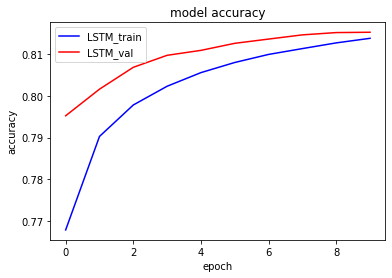

In [29]:
plt.plot(history.history['accuracy'], c= 'b')
plt.plot(history.history['val_accuracy'], c='r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LSTM_train', 'LSTM_val'], loc='upper left')
plt.savefig('model_accuracy')

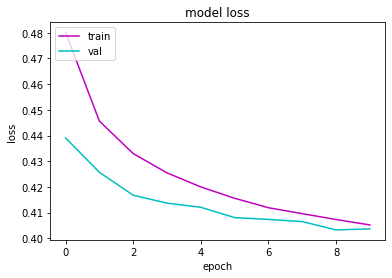

In [30]:
plt.plot(history.history['loss'], c='m')
plt.plot(history.history['val_loss'], c='c')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.savefig('model_loss')

In [31]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"

scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 3s 86ms/step


In [32]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
    plt.savefig('confusion_matrix')

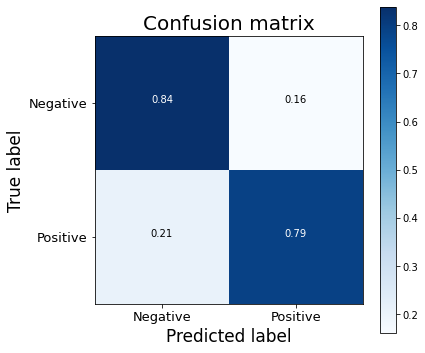

In [33]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [34]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.80      0.84      0.82    160542
    Positive       0.83      0.79      0.81    159458

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

